# ChatGPT Helped ResNet50 transfer learning version

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
import os
import cv2
import re
import numpy as np
from sklearn.model_selection import train_test_split

# Import data and label it

In [2]:
from random import shuffle

In [3]:
#train_images = os.open("./train/")
data = []
for files in os.listdir("./train"):
    #Resize all pictures to the same size
    image = cv2.resize(cv2.imread(os.path.join("./train/", files)),(224,224)) 
    #Split labels on yes or no
    label = re.split(r"\s\(\d+\)",files)[0]
    if label == "yes":
        data.append([np.array(image), np.array([1,0])])
    elif label == "no":
        data.append([np.array(image), np.array([0,1])])   
shuffle(data)        

In [4]:
len(data)

1043

### Assign train and validation data, scale x_data

In [5]:
X_data = np.array([i[0] for i in data]).reshape(-1, 224, 224, 3) 
y_data = np.array([i[1] for i in data])

# X ranges from 0.0 to 255.0, we will divide by 255.0 to scale it from 0.0 to 1.0
X_data = X_data.astype("float32")/255

In [6]:
print("Shape of X: ", X_data.shape)
print("Min val of X: ", X_data.min())
print("Max val of X: ", X_data.max())
print(y_data.shape)


Shape of X:  (1043, 224, 224, 3)
Min val of X:  0.0
Max val of X:  1.0
(1043, 2)


# Load ready model and add data augmentation

In [7]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [8]:
d_aug = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    vertical_flip=False,
    zoom_range=0.1,
    rescale=1./255
)

In [9]:
# Load ResNet50 model pre-trained on ImageNet
base_model = ResNet50(input_shape=(224, 224, 3), weights="imagenet", include_top=False)

In [10]:
# Add new top layers for classification
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.2)(x)
predictions = Dense(2, activation="sigmoid")(x)

In [11]:
# Combine the base model and top layers into a new model
model = keras.Model(inputs=base_model.input, outputs=predictions)

In [12]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

In [13]:
# Freeze the pre-trained layers
for layer in base_model.layers:
    layer.trainable = False

In [14]:
# Compile the model with binary cross-entropy loss and Adam optimizer
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

## Training the model

In [15]:
from sklearn.model_selection import KFold

In [16]:
kf = KFold(n_splits = 3, shuffle=True)#, random_state=42)

In [17]:
fold = 0

for train, test in kf.split(X_data):
    fold += 1
    print("training fold " + str(fold))
    X = X_data[train]
    y = y_data[train]
    x_validation = X_data[test]
    y_validation = y_data[test]

    model_name = "ResNet50-model-aug-fold" + str(fold)
    tb_callback = tf.keras.callbacks.TensorBoard(log_dir="ResNet50-aug/{}".format(model_name))
    # For TL models, augmentation seems to drag the results down. d_aug.flow(X, y)
    pre_tune_hist = model.fit(X, y, batch_size=32, epochs=5,
                          validation_data=(x_validation, y_validation), callbacks=[tb_callback])
    
model.save("punch-model-ResNet50.h5", overwrite=True, include_optimizer=True)

training fold 1
Epoch 1/5
22/22 [==============================] - 66s 3s/step - loss: 0.7319 - accuracy: 0.5468 - val_loss: 0.6977 - val_accuracy: 0.5115
Epoch 2/5
22/22 [==============================] - 61s 3s/step - loss: 0.6519 - accuracy: 0.6115 - val_loss: 0.6483 - val_accuracy: 0.6466
Epoch 3/5
22/22 [==============================] - 76s 4s/step - loss: 0.5948 - accuracy: 0.6964 - val_loss: 0.5800 - val_accuracy: 0.7040
Epoch 4/5
22/22 [==============================] - 96s 5s/step - loss: 0.5602 - accuracy: 0.7165 - val_loss: 0.5941 - val_accuracy: 0.6782
Epoch 5/5
22/22 [==============================] - 80s 4s/step - loss: 0.5460 - accuracy: 0.7367 - val_loss: 0.5338 - val_accuracy: 0.7270
training fold 2
Epoch 1/5
22/22 [==============================] - 91s 4s/step - loss: 0.5358 - accuracy: 0.7353 - val_loss: 0.4919 - val_accuracy: 0.7615
Epoch 2/5
22/22 [==============================] - 93s 4s/step - loss: 0.5272 - accuracy: 0.7568 - val_loss: 0.5076 - val_accuracy: 0.

## Plot loss vs val_loss, accuracy vs val_acc before fine tuning

In [18]:
import matplotlib.pyplot as plt

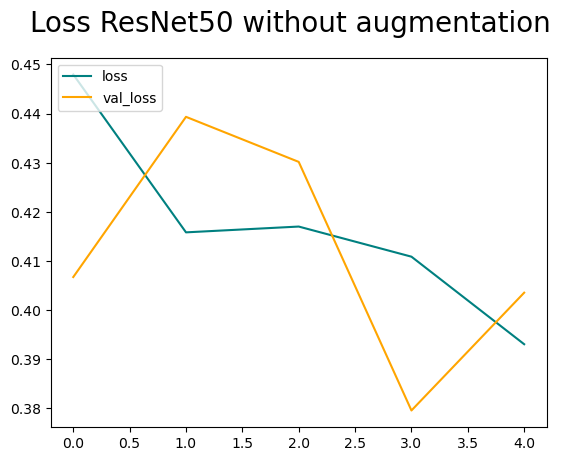

In [19]:
fig = plt.figure()
plt.plot(pre_tune_hist.history["loss"], color = "teal", label = "loss")
plt.plot(pre_tune_hist.history["val_loss"], color = "orange", label = "val_loss")
fig.suptitle("Loss ResNet50 without augmentation", fontsize=20)
plt.legend(loc="upper left")
plt.show()

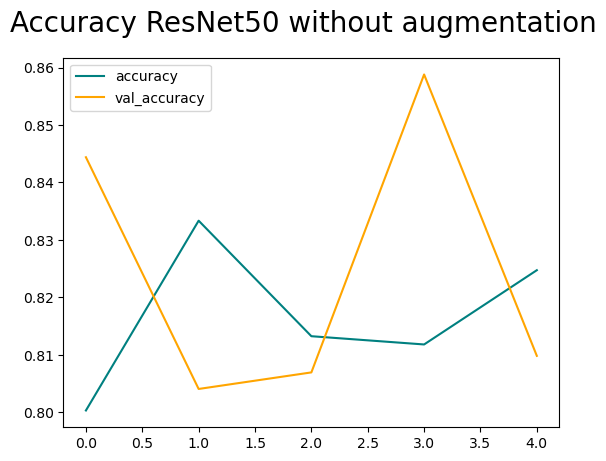

In [20]:
fig = plt.figure()
plt.plot(pre_tune_hist.history["accuracy"], color = "teal", label = "accuracy")
plt.plot(pre_tune_hist.history["val_accuracy"], color = "orange", label = "val_accuracy")
fig.suptitle("Accuracy ResNet50 without augmentation", fontsize=20)
plt.legend(loc="upper left")
plt.show()

# Test on new image

In [21]:
import matplotlib.pyplot as plt

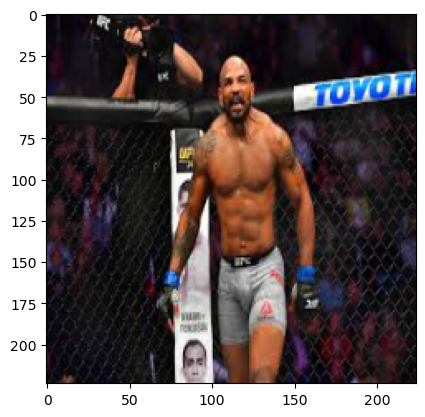

In [22]:
#Image that the model has not seen yet
img_array = cv2.imread("./test/no (4).jpg")
img_array = cv2.cvtColor(img_array, cv2.COLOR_RGB2BGR)
new_array = cv2.resize(img_array, (224,224))
plt.imshow(new_array)
plt.show()

### Make a prediction

In [23]:
y_test_pred = model.predict(np.expand_dims(new_array/255, 0))

1/1 [==============================] - 1s 1s/step


In [24]:
y_test_pred

array([[0.11870942, 0.8856923 ]], dtype=float32)

# Confusion matrix

### for the predictions, create a separate dataset with pictures it has not seen before, not x_val?

In [25]:
#this one was named predictions before, which already existed in the CNN modelling as a variable
predicted = model.predict(x_validation) 
predicted.shape

11/11 [==============================] - 26s 2s/step


(347, 2)

In [26]:
predicted

array([[0.9656458 , 0.03876289],
       [0.57059485, 0.45331717],
       [0.7904855 , 0.22355428],
       [0.93504536, 0.0693878 ],
       [0.95065403, 0.05538867],
       [0.8600731 , 0.1496432 ],
       [0.46785972, 0.51338816],
       [0.11114094, 0.89348584],
       [0.15856628, 0.8476852 ],
       [0.7612492 , 0.2527018 ],
       [0.1544969 , 0.8321395 ],
       [0.04098316, 0.96067876],
       [0.7551171 , 0.25896356],
       [0.9528641 , 0.05263278],
       [0.67194366, 0.35612842],
       [0.72474706, 0.29501516],
       [0.5286922 , 0.4871302 ],
       [0.22423114, 0.76599616],
       [0.550145  , 0.45883262],
       [0.9607678 , 0.0435015 ],
       [0.48855948, 0.53963816],
       [0.87658155, 0.13397166],
       [0.94179887, 0.06454387],
       [0.4162712 , 0.59532815],
       [0.13529225, 0.8683026 ],
       [0.09332408, 0.9074202 ],
       [0.08459795, 0.91563404],
       [0.32202736, 0.6926416 ],
       [0.89334965, 0.11447881],
       [0.8504186 , 0.15965866],
       [0.

In [27]:
np.round(predicted)

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.

In [28]:
predicted.mean()

0.50362813

In [29]:
# Round the predictions to be able to show them in the confusion matrix
rounded_predictions = np.argmax(predicted, axis=-1)
rounded_predictions

array([0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0,
       0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1,
       1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1,
       0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0,
       1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0,
       0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1,
       1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1,
       0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0,
       1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1,
       0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0,

### Convert the array to the real values

In [30]:
rounded_predictions=(~rounded_predictions.astype(bool)).astype(int)
rounded_predictions

array([1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1,
       1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1,
       1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1,
       1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0,
       0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1,
       1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0,
       1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1,
       0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1,
       1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0,
       0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0,
       1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1,
       0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0,
       1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1,

### The above rounded predictions means that all the predictions were [0,1], or index [1], had the highest probability, so what is being displayed is the nr of the index with the highest probability. Which in turn means this model only predicts No punch in every single prediction since we decided No punch = [0,1].

## Extract y_labels by taking the first element in each array, 1 = punch, 0 = no punch

In [31]:
#Extract values from index 0 in the array
i = 0
y_val_extract = []

for pair in y_validation:
    y_val_extract.append(y_validation[i][0])
    i+=1
y_val_extract;

In [32]:
from sklearn.metrics import confusion_matrix
import itertools

In [33]:
cm = confusion_matrix(y_true=y_val_extract, y_pred=rounded_predictions)
cm


array([[127,  54],
       [ 12, 154]], dtype=int64)

In [34]:
tn, fp, fn, tp = confusion_matrix(y_true=y_val_extract, y_pred=rounded_predictions).ravel()
(tn, fp, fn, tp)

(127, 54, 12, 154)

In [35]:
#Code copied from sklearn
def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='Confusion matrix',
                        cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[127  54]
 [ 12 154]]


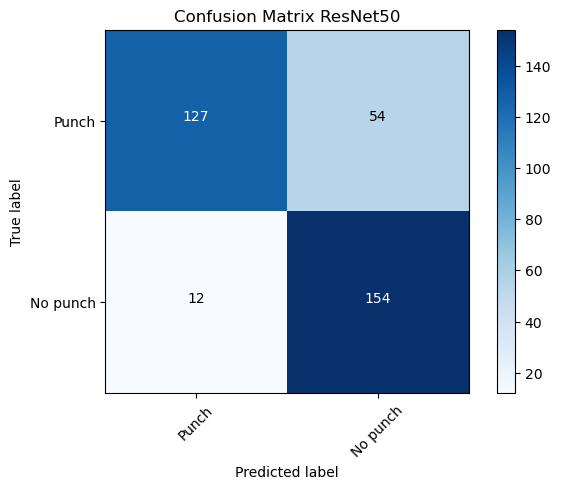

In [36]:
cm_plot_labels = ["Punch", "No punch"]
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title="Confusion Matrix ResNet50")

# Test predicting

In [37]:
pred_data = []
for files in os.listdir("./test"):
    #Resize all pictures to the same size
    p_image = cv2.resize(cv2.imread(os.path.join("./test/", files)),(224,224)) 
    p_image = cv2.cvtColor(p_image, cv2.COLOR_RGB2BGR)
    #Split labels on yes or no
    label = re.split(r"\s\(\d+\)",files)[0]
    if label == "yes":
        pred_data.append([np.array(p_image), np.array([1,0])])
    elif label == "no":
        pred_data.append([np.array(p_image), np.array([0,1])]) 

In [38]:
np.asanyarray(pred_data).shape

c:\Users\jonat\Anaconda3\envs\mmascore\lib\site-packages\ipykernel_launcher.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  """Entry point for launching an IPython kernel.


(10, 2)

In [39]:
X_pred = np.array([i[0] for i in pred_data]).reshape(-1, 224, 224, 3) 
y_pred = np.array([i[1] for i in pred_data])

X_pred = X_pred.astype("float32")/255

In [40]:
from tensorflow.keras.models import load_model

In [41]:
res_model = load_model("punch-model-ResNet50.h5")

In [42]:
res_model.predict(X_pred) #np.expand_dims(X_pred/255, 0)

1/1 [==============================] - 2s 2s/step


array([[0.5462418 , 0.48469198],
       [0.80960953, 0.20498869],
       [0.2332683 , 0.7762071 ],
       [0.11870942, 0.88569236],
       [0.47640088, 0.564042  ],
       [0.78230375, 0.23048365],
       [0.5142852 , 0.49487332],
       [0.8206057 , 0.19342363],
       [0.08360495, 0.91945386],
       [0.86462915, 0.15197416]], dtype=float32)

In [43]:
for i in y_pred:
    print(i)

[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[1 0]
[1 0]
[1 0]
[1 0]
[1 0]


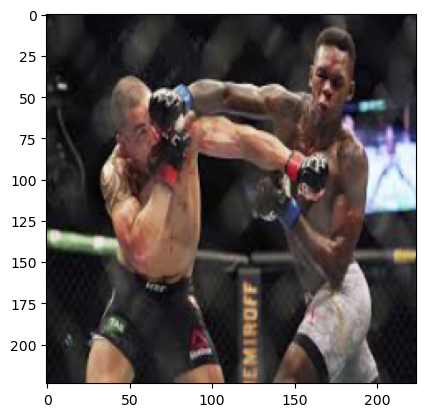

In [44]:
plt.imshow(X_pred[9])

In [45]:
res = res_model.evaluate(X_pred, y_pred, batch_size=10)
print("test loss, test acc:", res)

1/1 [==============================] - 2s 2s/step - loss: 0.7162 - accuracy: 0.7000
test loss, test acc: [0.7161625027656555, 0.699999988079071]
